<a href="https://colab.research.google.com/github/awaaat/Machine_learning-Deep_learning/blob/main/Final_End_to_End_Text_Classification_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import os
import tensorflow as tf
import re
import numpy as np
import shutil
import matplotlib.pyplot as plt
import string
from tensorflow.keras import losses
from tensorflow.keras import layers

In [2]:
#Let is download and fetchh the database
dataset_link = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = tf.keras.utils.get_file(fname = "aclImdb_v1", origin = dataset_link, untar = True, cache_dir = ".", cache_subdir = " ")
dataset_dir = os.path.join(os.path.dirname(dataset), "aclImdb")

84125825/84125825 [==============================] - 13s 0us/step


In [3]:
os.listdir(dataset_dir)

['test', 'imdb.vocab', 'imdbEr.txt', 'README', 'train']

In [4]:
#To get the train_dir...
train_dir = os.path.join(dataset_dir, "train")
os.listdir(train_dir)

['neg',
 'urls_pos.txt',
 'unsup',
 'labeledBow.feat',
 'unsupBow.feat',
 'pos',
 'urls_neg.txt',
 'urls_unsup.txt']

In [5]:
test_dir = os.path.join(dataset_dir, "test")
os.listdir(test_dir)

['neg', 'urls_pos.txt', 'labeledBow.feat', 'pos', 'urls_neg.txt']

In [6]:
#Let us fetch a sample file in the train set
sample_file = os.path.join(train_dir, "pos/1181_9.txt")
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [7]:
os.listdir(train_dir)

['neg',
 'urls_pos.txt',
 'unsup',
 'labeledBow.feat',
 'unsupBow.feat',
 'pos',
 'urls_neg.txt',
 'urls_unsup.txt']

In [8]:
remove_dir = os.path.join(train_dir, "unsup")
shutil.rmtree(remove_dir)

In [9]:
os.listdir(train_dir)

['neg',
 'urls_pos.txt',
 'labeledBow.feat',
 'unsupBow.feat',
 'pos',
 'urls_neg.txt',
 'urls_unsup.txt']

In [10]:
#Ceate a validation set
batch_size = 32
seed = 42
raw_training_dataset = tf.keras.utils.text_dataset_from_directory(train_dir, batch_size = batch_size, seed = seed, shuffle = True, validation_split=0.2, subset = "training" )

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [11]:
raw_validation_dataset = tf.keras.utils.text_dataset_from_directory(train_dir,
                                                                    batch_size = batch_size,
                                                                    seed = seed,
                                                                    shuffle = True,
                                                                    validation_split = 0.2,
                                                                    subset  = "validation")

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [12]:
#Let us print out a few samples of our training samples
for sample_train_batch, label_batch in raw_training_dataset.take(1):
  for i in range(5):
    print(f"Review: {sample_train_batch.numpy()[i]}")
    print(f"Label: {label_batch.numpy()[i]}")

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label: 0
Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get in

In [13]:
raw_training_dataset.class_names[1]

'pos'

In [14]:
raw_testing_dataset = tf.keras.utils.text_dataset_from_directory(test_dir)

Found 25000 files belonging to 2 classes.


Preparing the data for training

In [15]:
""" This will largely involve standardize, tokenize, and vectorize the data using the helpful tf.keras.layers.TextVectorization layer. """
#Ceate a custom standardizer
def custom_standardizer(input_data):
  #Convert to lower case
  lower_case = tf.strings.lower(input_data)
  #Strip off the html tags and space
  stripped_html = tf.strings.regex_replace(lower_case, "<br />", " ")
  return tf.strings.regex_replace(stripped_html, "[%s]" % re.escape(string.punctuation), " ")

In [16]:
#We will have vectorizing layer
maximum_features = 10000
sequence_length = 250
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens = maximum_features,
                                                    standardize = custom_standardizer,
                                                    output_mode = "int",
                                                    output_sequence_length=sequence_length)

#The next stage will require us to make a text-only dataset (without labels), then call adapt

In [17]:
training_text = raw_training_dataset.map(lambda x, y:x)
vectorize_layer.adapt(training_text)

In [18]:
#Let us check the results of using this vectorize thing
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [19]:
text_batch, label_batch = next(iter(raw_training_dataset))
first_review, first_label = text_batch[0], label_batch[0]
print(f"Review: {first_review}")
print(f"Label: {raw_training_dataset.class_names[first_label]}")
print(f"Vectorized_text: {vectorize_text(first_review, first_label)}")

Review: b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.'
Label: neg
Vectorized_text: (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  85,   17,  258,    2,  221,    1,  580,   32,  235,   11, 2480,
           1,   53,   23,   28,  418,  256,   12,  314,  280,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    

In [20]:
# We can lookup the token (string) that each integer corresponds to by calling .get_vocabulary() on the layer.
print(f"1420: {vectorize_layer.get_vocabulary()[1420]}")

1420: falling


#We are nearly ready to train our model. As a final preprocessing step, we will apply the TextVectorization layer we created earlier to the train, validation, and test dataset.

In [21]:
training_set = raw_training_dataset.map(vectorize_text)
validation_set = raw_validation_dataset.map(vectorize_text)
testing_set = raw_testing_dataset.map(vectorize_text)

In [22]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = training_set.cache().prefetch(buffer_size =AUTOTUNE )
validation_ds = validation_set.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = testing_set.cache().prefetch(buffer_size = AUTOTUNE)

#The Juicy Part -- Creating our Neural Network

In [23]:
embedding_dim = 16

In [24]:
model = tf.keras.Sequential([
    layers.Embedding(maximum_features, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1, activation = "sigmoid")
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160017 (625.07 KB)
Trainable params: 160017 (625.07 KB)
Non-trainable params: 0 (0.00 Byte)
________________

#Loss function and optimizer A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), you'll use losses.BinaryCrossentropy loss function.

In [25]:
model.compile(loss = losses.BinaryCrossentropy(),
              optimizer = "adam",
              metrics = [tf.metrics.BinaryAccuracy(threshold = 0.5)])

#Let us now Train the model

In [26]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 56s 85ms/step - loss: 0.6628 - binary_accuracy: 0.6958 - val_loss: 0.6110 - val_binary_accuracy: 0.7696
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.5439 - binary_accuracy: 0.7983 - val_loss: 0.4942 - val_binary_accuracy: 0.8194
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 0.4398 - binary_accuracy: 0.8446 - val_loss: 0.4172 - val_binary_accuracy: 0.8466
Epoch 4/10
625/625 [==============================] - 3s 4ms/step - loss: 0.3734 - binary_accuracy: 0.8688 - val_loss: 0.3722 - val_binary_accuracy: 0.8586
Epoch 5/10
625/625 [==============================] - 3s 4ms/step - loss: 0.3326 - binary_accuracy: 0.8791 - val_loss: 0.3443 - val_binary_accuracy: 0.8666
Epoch 6/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3017 - binary_accuracy: 0.8891 - val_loss: 0.3257 - val_binary_accuracy: 0.8720
Epoch 7/10
625/625 [==============================] - 3s 4ms/s

In [27]:
for epoch in range(epochs):
  print(epoch)
  print(model.fit(train_ds, validation_data=validation_ds))

0
625/625 [==============================] - 3s 4ms/step - loss: 0.2167 - binary_accuracy: 0.9219 - val_loss: 0.2898 - val_binary_accuracy: 0.8806
1
625/625 [==============================] - 5s 7ms/step - loss: 0.2058 - binary_accuracy: 0.9257 - val_loss: 0.2879 - val_binary_accuracy: 0.8828
2
625/625 [==============================] - 4s 7ms/step - loss: 0.1964 - binary_accuracy: 0.9301 - val_loss: 0.2876 - val_binary_accuracy: 0.8816
3
625/625 [==============================] - 3s 5ms/step - loss: 0.1872 - binary_accuracy: 0.9349 - val_loss: 0.2880 - val_binary_accuracy: 0.8820
4
625/625 [==============================] - 3s 4ms/step - loss: 0.1781 - binary_accuracy: 0.9370 - val_loss: 0.2890 - val_binary_accuracy: 0.8816
5
625/625 [==============================] - 2s 4ms/step - loss: 0.1693 - binary_accuracy: 0.9426 - val_loss: 0.2910 - val_binary_accuracy: 0.8810
6
625/625 [==============================] - 2s 4ms/step - loss: 0.1620 - binary_accuracy: 0.9445 - val_loss: 0.2933 -

In [28]:
#Let us evaluatloss
loss, accuracy = model.evaluate(test_ds)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

782/782 [==============================] - 4s 5ms/step - loss: 0.3396 - binary_accuracy: 0.8653
Loss: 0.3396364748477936
Accuracy: 0.8653200268745422


In [30]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

In [35]:
#Let us do some plotting
accuracy = history_dict["binary_accuracy"]
validation_accuracy = history_dict["val_binary_accuracy"]
loss = history_dict["loss"]
validation_loss = history_dict["val_loss"]

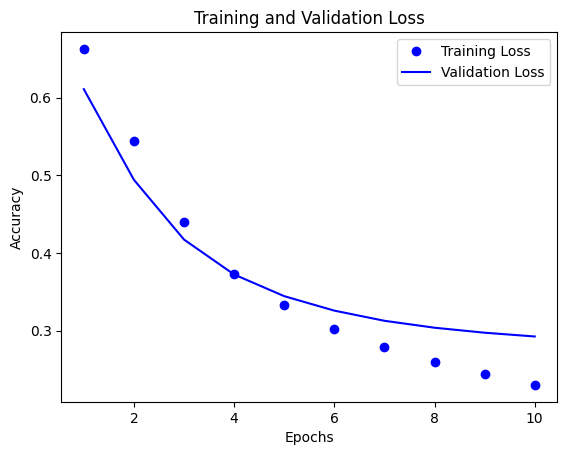

In [37]:
#Plotting the loss metrics
epochs = range(1, len(accuracy)+1)
plt.plot(epochs, loss, "bo", label = "Training Loss")
plt.plot(epochs, validation_loss, "b", label = "Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

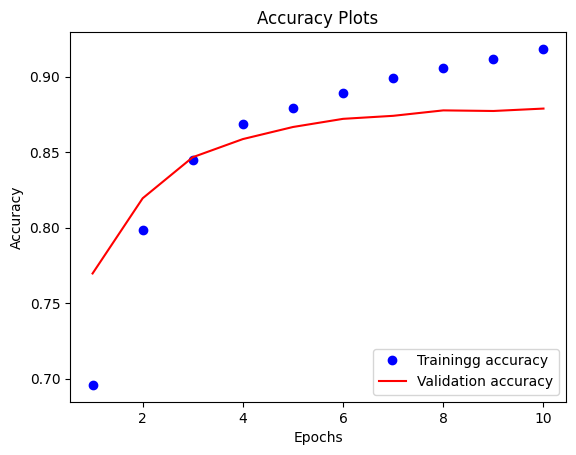

In [43]:
#Ploting the accuracy metrics
epochs = range(1, len(accuracy)+1)
plt.plot(epochs, accuracy, "bo", label = "Trainingg accuracy")
plt.plot(epochs, validation_accuracy, "r", label = "Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Plots")
plt.legend(loc = "lower right")

plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss decreases with each epoch and the training accuracy increases with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak before the training accuracy. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations specific to the training data that do not generalize to test data.

For this particular case, you could prevent overfitting by simply stopping the training when the validation accuracy is no longer increasing. One way to do so is to use the tf.keras.callbacks.EarlyStopping callback.

#Export the model
In the code above, you applied the TextVectorization layer to the dataset before feeding text to the model. If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include the TextVectorization layer inside your model. To do so, you can create a new model using the weights you just trained

In [46]:
saved_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation("sigmoid")
])

saved_model.compile(
    loss = losses.BinaryCrossentropy(from_logits = False), optimizer = "adam", metrics = ["accuracy"]
)

In [47]:
final_accuracy, final_loss = saved_model.evaluate(raw_testing_dataset)
print(f"Final Accuracy: {final_accuracy}")
print(f"Final Loss: {final_loss}")

782/782 [==============================] - 4s 5ms/step - loss: 0.5782 - accuracy: 0.5014
Final Accuracy: 0.5782091617584229
Final Loss: 0.5013599991798401


In [49]:
example_text_for_prediction = tf.constant([
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
  "I really enjoyed it"
])


saved_model.predict(example_text_for_prediction)

1/1 [==============================] - 0s 159ms/step


array([[0.6512475 ],
       [0.596991  ],
       [0.61206686]], dtype=float32)